In [1]:
import pandas as pd
import numpy as np
import requests
import string
import nltk
import matplotlib.pyplot as plt
from io import BytesIO
from statistics import mean
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#load data from github
url = 'https://raw.githubusercontent.com/cmcswiggan/CIND820/main/SMS_Spam_Dataset'
data = requests.get(url).content
smsData = pd.read_csv(BytesIO(data), sep = '\t', header = None, names = ['Category', 'SMS Message'])

#check data loaded as expected
smsData.head()

,Category,SMS Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#assign stopwords and punctuation to variables
stopWords = nltk.corpus.stopwords.words('english')
punctuation = string.punctuation

In [4]:
#pre_Process function defined - list required for lemmatization step

def pre_Process(sms):
    
    #toeknize and remove stopwords
    tokenize = nltk.tokenize.word_tokenize(sms)
    remove_stopwords = [word for word in tokenize if word not in stopWords]
    return remove_stopwords

#add processed column
smsData['Processed'] = smsData['SMS Message'].apply(lambda x: pre_Process(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, ,, crazy, .., Available, b..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, ..., U, c, already, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, n't, think, goes, usf, ,, lives, arou..."


In [5]:
#define function for lemmatizing words

def lemm (sms):
    
    lem = [lemmatizer.lemmatize(word) for word in sms]
    return lem

#replace processed column with lemmatized column
smsData['Processed'] = smsData['Processed'].apply(lambda x: lemm(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, jurong, point, ,, crazy, .., Available, b..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, early, hor, ..., U, c, already, ..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, n't, think, go, usf, ,, life, around,..."


In [6]:
#add cell with processed data as a string after processing
smsData['Processedstr'] = [' '.join(map(str, l)) for l in smsData['Processed']]

#assign 0 for ham and 1 for spam
for i in range(len(smsData['Category'])):
    if smsData.iloc[i, 0] == 'ham':
        smsData.iloc[i, 0] = 1
    else:
        smsData.iloc[i, 0] = 0

#remove unwanted columns
smsData = smsData[['Category', 'Processedstr']]

#check updated data frame
smsData.head()

,Category,Processedstr
0,1,"Go jurong point , crazy .. Available bugis n g..."
1,1,Ok lar ... Joking wif u oni ...
2,0,Free entry 2 wkly comp win FA Cup final tkts 2...
3,1,U dun say early hor ... U c already say ...
4,1,"Nah I n't think go usf , life around though"


In [7]:
#split data into 10 folds to run model on each fold
kf = KFold(n_splits = 10, shuffle = True, random_state = 5)

#counter
i = 0

#initiate empty lists and data frame
fold = []
acc = []
prec = []
rec = []
f1 = []
fprt = []
met = []
res = pd.DataFrame()

#split data/loop over each fold and run model 
for train_index, test_index in kf.split(smsData.Processedstr, smsData.Category):
    sms_train, sms_test, label_train, label_test = smsData.Processedstr[train_index], smsData.Processedstr[test_index], smsData.Category[train_index], smsData.Category[test_index]
    
    #labels as integers
    label_train = label_train.astype('int')
    label_test = label_test.astype('int')
    
    #fit and transform training and test data
    vectorizer = TfidfVectorizer(min_df=10)

    train_transformed = vectorizer.fit_transform(sms_train)

    test_transformed = vectorizer.transform(sms_test)
        
    #KNN model
    clf = KNeighborsClassifier(n_neighbors = 3)
    clf.fit(train_transformed, label_train)

    #assign predictor
    train_predict = clf.predict(test_transformed)

    #run confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_test, train_predict, labels = [1, 0]).ravel()
    
   #calculate accuracy, precision, recall, F1 score, False Positive Rate
    a = (tp + tn)/(tp + fp + fn + tn)
    p = tp/(tp + fp)
    r = tp/(tp + fn)
    f = (2 * (p * r))/(p + r)
    fpr = fp / (tn + fp)
    
    i = i + 1
    
    #append results to each empty list
    fold.append(i)
    acc.append(a)
    prec.append(p)
    rec.append(r)
    f1.append(f)
    fprt.append(fpr)
    met.append([tp, fp, tn, fn])

#fill dataframe with results from the model/cross-validation 
res['Fold'] = fold    
res['Accuracy'] = acc
res['Precision'] = prec
res['Recall'] = rec
res['F1'] = f1
res['FPR'] = fprt
res['Metrics'] = met

res

C:\conda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\conda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid thi

,Fold,Accuracy,Precision,Recall,F1,FPR,Metrics
0,1,0.926523,1.000000,0.487500,0.655462,0.000000,"[39, 0, 478, 41]"
1,2,0.944444,1.000000,0.523077,0.686869,0.000000,"[34, 0, 493, 31]"
2,3,0.949731,0.980769,0.653846,0.784615,0.002088,"[51, 1, 478, 27]"
3,4,0.940754,0.977273,0.573333,0.722689,0.002075,"[43, 1, 481, 32]"
4,5,0.919210,1.000000,0.470588,0.640000,0.000000,"[40, 0, 472, 45]"
5,6,0.938959,1.000000,0.564103,0.721311,0.000000,"[44, 0, 479, 34]"
6,7,0.940754,1.000000,0.521739,0.685714,0.000000,"[36, 0, 488, 33]"
7,8,0.947935,1.000000,0.602740,0.752137,0.000000,"[44, 0, 484, 29]"
8,9,0.946140,1.000000,0.634146,0.776119,0.000000,"[52, 0, 475, 30]"
9,10,0.951526,0.926829,0.612903,0.737864,0.006061,"[38, 3, 492, 24]"


In [8]:
#split list of list in dataframe
split = pd.DataFrame(res['Metrics'].to_list(), columns = ['TP', 'FP', 'TN', 'FN'])

#add split columns to results dataframe
res = pd.concat([res, split], axis = 1)

#drop combined columns
res.drop(columns = 'Metrics', inplace = True)

#check results dataframe
res

,Fold,Accuracy,Precision,Recall,F1,FPR,TP,FP,TN,FN
0,1,0.926523,1.000000,0.487500,0.655462,0.000000,39,0,478,41
1,2,0.944444,1.000000,0.523077,0.686869,0.000000,34,0,493,31
2,3,0.949731,0.980769,0.653846,0.784615,0.002088,51,1,478,27
3,4,0.940754,0.977273,0.573333,0.722689,0.002075,43,1,481,32
4,5,0.919210,1.000000,0.470588,0.640000,0.000000,40,0,472,45
5,6,0.938959,1.000000,0.564103,0.721311,0.000000,44,0,479,34
6,7,0.940754,1.000000,0.521739,0.685714,0.000000,36,0,488,33
7,8,0.947935,1.000000,0.602740,0.752137,0.000000,44,0,484,29
8,9,0.946140,1.000000,0.634146,0.776119,0.000000,52,0,475,30
9,10,0.951526,0.926829,0.612903,0.737864,0.006061,38,3,492,24


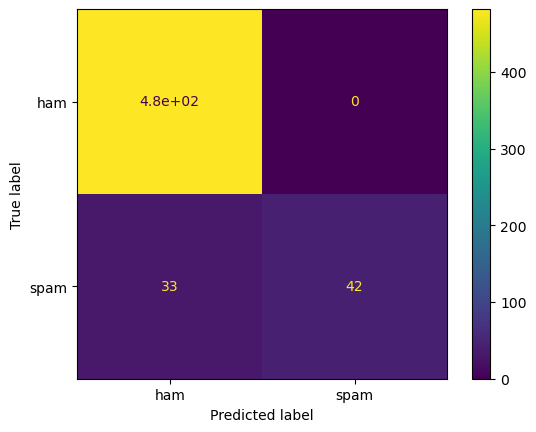

In [9]:
#Average fold results for visualization
TP = round(mean(res['TP']),0)
FP = round(mean(res['FP']),0)
TN = round(mean(res['TN']),0)
FN = round(mean(res['FN']),0)

#create array with results stored
data = np.array([[TN, FP], [FN, TP]])

#instantiate confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(data, display_labels = ['ham', 'spam'])

#plot
cm_display.plot()
plt.show()      

In [10]:
#store list to for use in statistical comparison
f1_knn_case2 = res.loc[:,'F1'].tolist()
fpr_knn_case2 = res.loc[:,'FPR'].tolist()

%store f1_knn_case2
%store fpr_knn_case2

Stored 'f1_knn_case2' (list)
Stored 'fpr_knn_case2' (list)
